# NLP Overview Walkthrough

Week 4- Day 2
<hr style="border:2px solid gray">

Dataframe 1 is available [here](https://skillstorm-my.sharepoint.com/:x:/p/nrivers/EU-ZXzzJPtJEmI_VKBYFE9EByyfj-0gzfb7GGmdJV1jR6g?e=72ATYK)

Dataframe 2 is available [here](https://skillstorm-my.sharepoint.com/:x:/p/nrivers/EXixxiv2qi9AgR44zmrhZi0BXUylzX0E3w5hlN6a_sMOqA?e=KsWRK2)

### Imports

In [1]:
#data maniplation imports
import pandas as pd
import unicodedata
import re

#nlp imports
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

#visual imports
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

#modeling imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import warnings
warnings.filterwarnings('ignore')

<hr style="border:2px solid grey">

## Acquisition

In [2]:
# Read the CSV files
df1 = pd.read_csv('corona_nlp.csv', encoding='ISO-8859-1')
df2 = pd.read_csv('corona_nlp2.csv', encoding='ISO-8859-1')

# Concatenate the two DataFrames and reset the index
df = pd.concat([df1, df2], ignore_index=True)

# Check the DataFrame
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserName,44955.0,22478.0,12977.535012,1.0,11239.5,22478.0,33716.5,44955.0
ScreenName,44955.0,67430.0,12977.535012,44953.0,56191.5,67430.0,78668.5,89907.0


<hr style="border:1px solid black">

## Prepare

### Dive deeper into ```UserName``` and ```ScreenName``` 

Let's check if a ```UserName``` can have more than one ```ScreenName```. If not, we can delete ```ScreenName``` because it is also just a unique identifier.

In [6]:
# Group by 'UserName' and count distinct 'ScreenName'
multiple_screen_names = df.groupby('UserName')['ScreenName'].nunique()

# Filter to find 'UserName' entries with more than 1 distinct 'ScreenName'
multiple_screen_names = multiple_screen_names[multiple_screen_names > 1]

# Display the result
print(multiple_screen_names)

Series([], Name: ScreenName, dtype: int64)


<div class="alert alert-block alert-success">
<b><u>Conclusion</u></b>: 
    
Each ```UserName``` only has one ```ScreenName```. We will drop ```ScreenName``` column. 

In [7]:
#drop ScreenName
df = df.drop(columns ='ScreenName')

<hr style="border:2px solid grey">

### Check for Nulls

In [8]:
#null count for each column
df.isnull().sum()

UserName            0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [9]:
#look into Location, only column with nulls
df.Location.value_counts()

United States             603
London, England           568
London                    565
New York, NY              429
Washington, DC            411
                         ... 
New York State of Mind      1
Bury, England               1
Brent, London               1
Wall, NJ                    1
Haverford, PA               1
Name: Location, Length: 13127, dtype: int64

### Clean up ```Location```

In [10]:
# Assuming df is your DataFrame
df['Location'] = df['Location'].replace({
    'New York State of Mind': 'New York, NY',
    'where others fear to follow': 'Unknown',
    'London': 'London, England',
    'Brent, London': 'London, England'})

# Fill NaN values in the 'location' column with 'Unknown'
df['Location'] = df['Location'].fillna('Unknown')

In [11]:
#look at the count again
df.Location.value_counts()

Unknown                       9428
London, England               1134
United States                  603
New York, NY                   430
Washington, DC                 411
                              ... 
Fort Saskatchewan, Alberta       1
Mansfield (Notts)                1
Bury, England                    1
Wall, NJ                         1
Haverford, PA                    1
Name: Location, Length: 13123, dtype: int64

In [12]:
#confirm nulls gone
df.isnull().sum()

UserName         0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

<hr style="border:2px solid grey">

### Feature Engineer

In [13]:
#convert 'TweetAt' to datetime
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%d-%m-%Y')

#create a new column for the month name
df['MonthName'] = df['TweetAt'].dt.month_name()

#create a new column for day of week
df['DayName'] = df['TweetAt'].dt.day_name()

#create a new column for the day number
df['Day'] = df['TweetAt'].dt.day


In [14]:
#look at the data with new features
df.sample(5)

,UserName,Location,TweetAt,OriginalTweet,Sentiment,MonthName,DayName,Day
28384,32183,"London, England",2020-04-04,@waitrose Your #Greenwich #waitrose store was ...,Extremely Negative,April,Saturday,4
41778,622,Unknown,2020-03-12,Sri Lankans: Let me panic stockpile groceries ...,Negative,March,Thursday,12
10937,14736,United States,2020-03-20,@DGPurser My question to whoever placed this n...,Negative,March,Friday,20
19949,23748,"Tinley Park, IL",2020-03-24,Whoever would of thought leavin my house to g...,Positive,March,Tuesday,24
28501,32300,"Watchfield, England",2020-04-04,"@VodafoneGroup \r\r\nGood job Vodafone, you've...",Extremely Positive,April,Saturday,4


<hr style="border:1px solid black">

## NLP Time

Our focus for NLP is the ```OriginalTweet``` feature. So, let's go through the steps.

In [15]:
#assign OriginalTweet column to text so we can clean it for nlp
nlp_text = df['OriginalTweet']
nlp_text

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
44950    Meanwhile In A Supermarket in Israel -- People...
44951    Did you panic buy a lot of non-perishable item...
44952    Asst Prof of Economics @cconces was on @NBCPhi...
44953    Gov need to do somethings instead of biar je r...
44954    I and @ForestandPaper members are committed to...
Name: OriginalTweet, Length: 44955, dtype: object

In [16]:
#lowercase
nlp_text = nlp_text.str.lower()

In [17]:
#confirm lowercase worked
nlp_text

0        @menyrbie @phil_gahan @chrisitv https://t.co/i...
1        advice talk to your neighbours family to excha...
2        coronavirus australia: woolworths to give elde...
3        my food stock is not the only one which is emp...
4        me, ready to go at supermarket during the #cov...
                               ...                        
44950    meanwhile in a supermarket in israel -- people...
44951    did you panic buy a lot of non-perishable item...
44952    asst prof of economics @cconces was on @nbcphi...
44953    gov need to do somethings instead of biar je r...
44954    i and @forestandpaper members are committed to...
Name: OriginalTweet, Length: 44955, dtype: object

In [18]:
#normalize each tweet in the 'OriginalTweet' column
nlp_text = nlp_text.apply(lambda x: unicodedata.normalize('NFKD', x)\
                                        .encode('ascii', 'ignore')\
                                        .decode('utf-8', 'ignore'))


ASCII Character Set (0–127):

	•	Letters: A-Z, a-z
	•	Digits: 0-9
	•	Punctuation: . , ! ? “ ’ : ; - _ + / * = and more
	•	Control characters: (like newlines \n, tabs \t)

Non-ASCII Characters:

These include characters that are used in other languages, special symbols, and emojis. For example:

	•	Accented characters: é, ñ, ü, ç
	•	Special symbols: €, ©, ™, ♥
	•	Non-English letters: 漢, 글, ע
	•	Emojis: 😊, 🚀, 🎉

In [19]:
#remove special characters and replaces it with blank
#apply the regex replacement to each value in the 'nlp_text' series
nlp_text = nlp_text.apply(lambda x: re.sub(r"[^a-z0-9\s]", '', x))

In [20]:
#confirm it's cleaned up
nlp_text

0        menyrbie philgahan chrisitv httpstcoifz9fan2pa...
1        advice talk to your neighbours family to excha...
2        coronavirus australia woolworths to give elder...
3        my food stock is not the only one which is emp...
4        me ready to go at supermarket during the covid...
                               ...                        
44950    meanwhile in a supermarket in israel  people d...
44951    did you panic buy a lot of nonperishable items...
44952    asst prof of economics cconces was on nbcphila...
44953    gov need to do somethings instead of biar je r...
44954    i and forestandpaper members are committed to ...
Name: OriginalTweet, Length: 44955, dtype: object

<div class="alert alert-block alert-success">
<b><u>Conclusion</u></b>: 

We have lowercased, removed non-ascii characters, removed special characters. Let's turn those steps into a function to use later.

In [21]:
def clean_series(series):
    '''
    This function takes in a pandas series (e.g., a column from a dataset).
    Each text entry is lowercased, encoded in ASCII (with non-ASCII characters removed),
    and special characters, including apostrophes, are removed.
    The cleaned text is returned as a series.
    '''
    
    # Define a helper function for cleaning individual strings
    def basic_clean(string):
        # Lowercase the string
        string = string.lower()

        # Normalize (remove non-ASCII characters)
        string = unicodedata.normalize('NFKD', string)\
                            .encode('ascii', 'ignore')\
                            .decode('utf-8', 'ignore')

        # Remove special characters, only keeping letters, numbers, and spaces (remove apostrophes)
        string = re.sub(r"[^a-z0-9\s]", '', string)
        
        # Remove words with numbers
        string = re.sub(r'\b\w*\d\w*\b', '', string)
    
        # Remove words with excessive repeated characters (e.g., "aaaaa", "aaannnddd")
        string = re.sub(r'\b\w*([a-z])\1{2,}\w*\b', '', string)  # Matches repeated characters
    
        # Remove words that are too short (1-2 characters)
        string = re.sub(r'\b\w{1,2}\b', '', string)
    
        # Remove words that are too long (e.g., longer than 15 characters)
        string = re.sub(r'\b\w{16,}\b', '', string)

        return string

    # Apply the basic_clean function to each element in the series
    return series.apply(basic_clean)

<hr style="border:1px solid black">

## Tokenize our text

In [22]:
# Create the tokenizer
tokenizer = nltk.tokenize.ToktokTokenizer()

In [23]:
# Use the tokenizer on each element in the series
nlp_text = nlp_text.apply(lambda x: tokenizer.tokenize(x, return_str=True))

In [24]:
nlp_text

0        menyrbie philgahan chrisitv httpstcoifz9fan2pa...
1        advice talk to your neighbours family to excha...
2        coronavirus australia woolworths to give elder...
3        my food stock is not the only one which is emp...
4        me ready to go at supermarket during the covid...
                               ...                        
44950    meanwhile in a supermarket in israel people da...
44951    did you panic buy a lot of nonperishable items...
44952    asst prof of economics cconces was on nbcphila...
44953    gov need to do somethings instead of biar je r...
44954    i and forestandpaper members are committed to ...
Name: OriginalTweet, Length: 44955, dtype: object

<div class="alert alert-block alert-success">
<b><u>Conclusion</u></b>: 
    
The features have been tokenized. Let's turn those steps into a function to use later.
    
</div>

In [25]:
def tokenize_series(series):
    '''
    This function takes in a pandas series (e.g., a column from a dataset).
    Each row is tokenized using the ToktokTokenizer and returns a list of tokens.
    '''
    
    # Define a helper function for tokenizing individual strings
    def tokenize(string):
        # Create the tokenizer
        tokenizer = nltk.tokenize.ToktokTokenizer()

        # Use the tokenizer to tokenize the string and return as a list of tokens
        tokens = tokenizer.tokenize(string)

        return tokens

    # Apply the tokenize function to each element in the series
    return series.apply(tokenize)

<hr style="border:1px solid black">

## Lemmatize our text

In [26]:
#create the lemmatizer
wnl = nltk.stem.WordNetLemmatizer()

In [27]:
# Apply lemmatization
nlp_text = nlp_text.apply(lambda x: ' '.join([wnl.lemmatize(word) for word in x.split()]))

In [28]:
nlp_text.head()

0    menyrbie philgahan chrisitv httpstcoifz9fan2pa...
1    advice talk to your neighbour family to exchan...
2    coronavirus australia woolworth to give elderl...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: OriginalTweet, dtype: object

<div class="alert alert-block alert-success">
<b><u>Conclusion</u></b>: 
    
The features have been lemmatized. Let's turn those steps into a function to use later.

In [29]:
def lemmatize_series(series):
    '''
    This function takes in a pandas series (e.g., a column from a dataset),
    lemmatizes each text entry in the series, and returns the lemmatized series.
    '''
    # Create a helper function for lemmatizing individual strings
    def lemmatize(text):
        # Create the lemmatizer
        wnl = nltk.stem.WordNetLemmatizer()
        
        # Lemmatize each word in the text
        lemmas = [wnl.lemmatize(word) for word in text.split()]
        
        # Join the lemmatized words back into a single string
        text_lemmatized = ' '.join(lemmas)

        return text_lemmatized

    # Apply the lemmatization to each entry in the series
    return series.apply(lemmatize)

<hr style="border:1px solid black">

## Remove StopWords

Assign a list for ```extra words``` and ```excluded words```

In [30]:
# Create a set of words that start with 'http' from the 'OriginalTweet' column
extra_words = set(word for tweet in df['OriginalTweet'] for word in tweet.split() if word.startswith('http'))

# Convert the set to a list (if needed)
extra_words = list(extra_words)

excluded_words = []

In [31]:
#assign variable for stopword list
stopword_list = stopwords.words('english')

#how many words are in the list
len(stopword_list)

#what are they
stopword_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [32]:
#remove excluded words from stopword list
stopword_list = set(stopword_list) - set(excluded_words)

#add the extra words to the stopword list
stopword_list = stopword_list.union(set(extra_words))

In [33]:
#split the string into words
# Apply the split method to each element in the pandas Series
split_words_series = nlp_text.apply(lambda x: x.split())

#check the result
split_words_series

0        [menyrbie, philgahan, chrisitv, httpstcoifz9fa...
1        [advice, talk, to, your, neighbour, family, to...
2        [coronavirus, australia, woolworth, to, give, ...
3        [my, food, stock, is, not, the, only, one, whi...
4        [me, ready, to, go, at, supermarket, during, t...
                               ...                        
44950    [meanwhile, in, a, supermarket, in, israel, pe...
44951    [did, you, panic, buy, a, lot, of, nonperishab...
44952    [asst, prof, of, economics, cconces, wa, on, n...
44953    [gov, need, to, do, somethings, instead, of, b...
44954    [i, and, forestandpaper, member, are, committe...
Name: OriginalTweet, Length: 44955, dtype: object

In [34]:
#create a list of words that are not stopwords
filtered_words_series = split_words_series.apply(lambda words: [word for word in words if word.lower() not in stopword_list])

#check the result
filtered_words_series

0        [menyrbie, philgahan, chrisitv, httpstcoifz9fa...
1        [advice, talk, neighbour, family, exchange, ph...
2        [coronavirus, australia, woolworth, give, elde...
3        [food, stock, one, empty, please, dont, panic,...
4        [ready, go, supermarket, covid19, outbreak, im...
                               ...                        
44950    [meanwhile, supermarket, israel, people, dance...
44951    [panic, buy, lot, nonperishable, item, echo, n...
44952    [asst, prof, economics, cconces, wa, nbcphilad...
44953    [gov, need, somethings, instead, biar, je, rak...
44954    [forestandpaper, member, committed, safety, em...
Name: OriginalTweet, Length: 44955, dtype: object

In [35]:
# Apply the split and join back to a string
#and assign to original nlp_text column
#now cleaned
nlp_text = filtered_words_series.apply(lambda x: ' '.join(x))

# Check the result
nlp_text

0        menyrbie philgahan chrisitv httpstcoifz9fan2pa...
1        advice talk neighbour family exchange phone nu...
2        coronavirus australia woolworth give elderly d...
3        food stock one empty please dont panic enough ...
4        ready go supermarket covid19 outbreak im paran...
                               ...                        
44950    meanwhile supermarket israel people dance sing...
44951    panic buy lot nonperishable item echo need foo...
44952    asst prof economics cconces wa nbcphiladelphia...
44953    gov need somethings instead biar je rakyat ass...
44954    forestandpaper member committed safety employe...
Name: OriginalTweet, Length: 44955, dtype: object

<div class="alert alert-block alert-success">
<b><u>Conclusion</u></b>: 

Stopwords have been removed from the feature. Let's turn those steps into a function to use later.

In [36]:
# Define extra words list (you can add more custom words if needed)
extra_words = []

# Define excluded words list
excluded_words = []

# Assign the stopword list
stopword_list = set(stopwords.words('english')).union(set(extra_words))

def remove_stopwords_series(series):
    '''
    This function takes in a pandas series (e.g., a column from a dataset),
    and removes stopwords, including words that start with 'http'.
    '''
    # Helper function to remove stopwords and words starting with 'http'
    def remove_stopwords(string):
        # Split the string into words
        words = string.split()

        # Filter out stopwords and words that start with 'http' or 'https'
        filtered_words = [word for word in words if word not in stopword_list and not word.startswith('http')]

        # Join the filtered words back into a string
        string_without_stopwords = ' '.join(filtered_words)

        return string_without_stopwords

    # Apply the remove_stopwords function to each element in the series
    return series.apply(remove_stopwords)


<hr style="border:2px solid black">
<hr style="border:2px solid black">

## Let's use the functions we created

In [37]:
# Apply all transformations step by step on the 'OriginalTweet' column

# normalize, lowercase, remove special characters
df['FinalTweet'] = clean_series(df['OriginalTweet'])

#lemmatize tokens
df['FinalTweet'] = lemmatize_series(df['FinalTweet'])

#remove stopwords from lemmatized tokens
df['FinalTweet'] = remove_stopwords_series(df['FinalTweet'])

#tokenize text
df['FinalTweet'] = tokenize_series(df['FinalTweet'])

# Check the result
df['FinalTweet'].head()

0                      [menyrbie, philgahan, chrisitv]
1    [advice, talk, neighbour, family, exchange, ph...
2    [coronavirus, australia, woolworth, give, elde...
3    [food, stock, one, empty, please, dont, panic,...
4    [ready, supermarket, outbreak, paranoid, food,...
Name: FinalTweet, dtype: object

<hr style="border:2px solid black">

# Explore

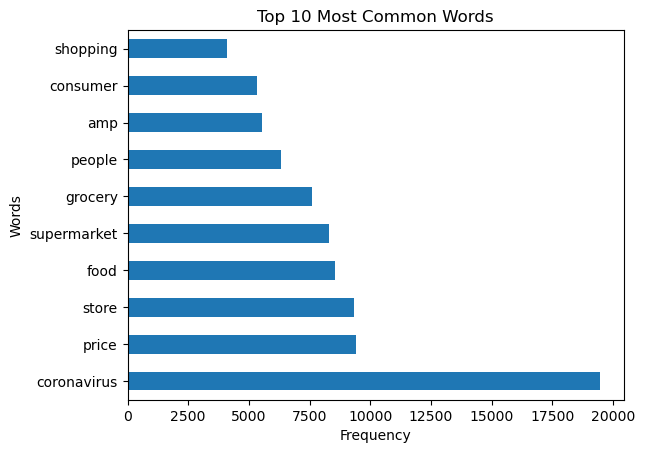

In [38]:
# Step 1: Join the tokens in each row back into a single string
df['FinalTweet'] = df['FinalTweet'].apply(lambda x: ' '.join(x))

# Step 2: Join all the text in the 'FinalTweet' column into a single string
all_words = ' '.join(df['FinalTweet'])

# Step 3: Split the string into a list of words
words_list = all_words.split()

# Step 4: Convert the words list into a pandas Series
words_series = pd.Series(words_list)

# Step 5: Get the top 10 most common words (or bigrams if you're working with those)
top_10_words = words_series.value_counts().head(10)

# Step 6: Plot the top 10 most common words as a horizontal bar chart
top_10_words.plot(kind='barh')
plt.title('Top 10 Most Common Words')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.show()

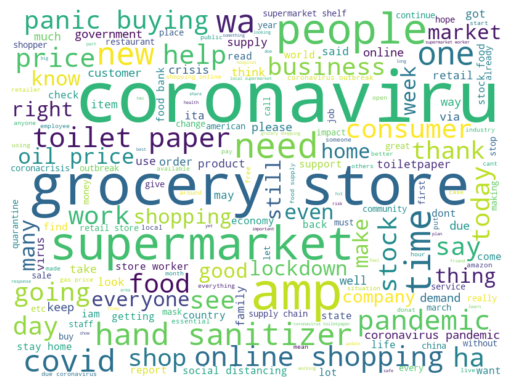

In [39]:
# Generate the word cloud
img = WordCloud(background_color='white', width=800, height=600).generate(all_words)

# Display the word cloud
plt.imshow(img, interpolation='bilinear')
plt.axis('off')
plt.show()

In [40]:
# Step 4: Generate bigrams from the list of words
bigrams_list = list(nltk.bigrams(words_list))

# Step 5: Convert the bigrams into a pandas Series and count their occurrences
bigrams_series = pd.Series(bigrams_list).value_counts()

# Step 6: Check the top 10 most frequent bigrams
print(bigrams_series.head(10))

(grocery, store)           5781
(hand, sanitizer)          1570
(online, shopping)         1562
(toilet, paper)            1541
(panic, buying)            1218
(oil, price)               1091
(coronavirus, pandemic)     873
(social, distancing)        640
(food, bank)                601
(stock, food)               554
dtype: int64


Text(0.5, 0, 'Frequency')

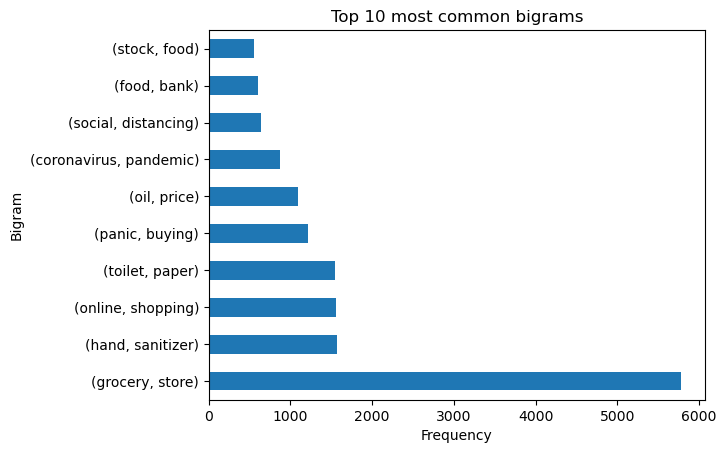

In [41]:
#visualize top ten
bigrams_series.head(10).plot.barh()
plt.title('Top 10 most common bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')

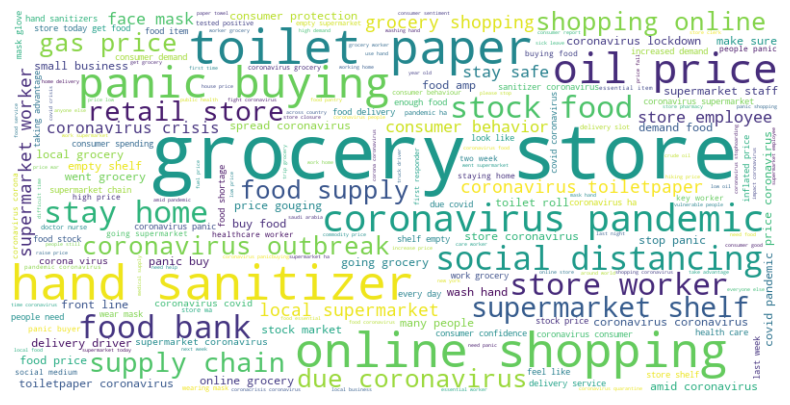

In [42]:
# Step 1: Convert bigrams to a readable string format for the word cloud
# For example, ('covid', 'pandemic') becomes "covid pandemic"
bigram_dict = { ' '.join(bigram): count for bigram, count in bigrams_series.items() }

# Step 2: Generate the word cloud for bigrams
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_dict)

# Step 3: Visualize the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<hr style="border:2px solid black">

## Metrics

### Word Frequency

In [43]:
#create a series with words split and value counts for each word
all_words = ' '.join(df['FinalTweet']).split()

# Convert the list of words into a pandas Series and count the frequency of each word
tweet_freq = pd.Series(all_words).value_counts()

#check top 10 words
tweet_freq.head(10)

coronavirus    19462
price           9401
store           9347
food            8557
supermarket     8299
grocery         7612
people          6323
amp             5531
consumer        5341
shopping        4111
dtype: int64

### Count Vectorizer

In [44]:
# Assuming df['FinalTweet'] is your text data
data = df['FinalTweet']

# Create the CountVectorizer instance
cv = CountVectorizer()

# Fit and transform the cleaned data into a bag-of-words
bag_of_words = cv.fit_transform(data)

In [45]:
# Convert the bag-of-words matrix into a DataFrame
bow_df = pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names_out())

# Display the resulting DataFrame
bow_df.sample(5)

,aa,aabout,aabta,aabutan,aaccidental,aacopd,aacounty,aacountygovt,aacross,aadam,...,zusammenhalten,zuschlage,zusendung,zvikwereti,zwd,zweli,zwoferink,zxspectrom,zynpbyhn,zypisfy
4675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This is not very useful for demonstration purposes because it alphabetizes every token and shows you the count vectorizer for that. Let's look at just the top 20 words.

In [46]:
# Step 4: Select the top 20 most frequent words
top_20_words = tweet_freq.head(20).index.tolist()

# Step 5: Create a new CountVectorizer limited to the top 20 words
cv_top_20 = CountVectorizer(vocabulary=top_20_words)

# Step 6: Fit and transform the data again to get the bag-of-words for top 20 words
bag_of_words_top_20 = cv_top_20.fit_transform(data)

# Step 7: Convert the bag-of-words matrix into a DataFrame
bow_df_top_20 = pd.DataFrame(bag_of_words_top_20.todense(), columns=cv_top_20.get_feature_names_out())

# Display the resulting DataFrame for the top 20 words
bow_df_top_20.sample(10)

,coronavirus,price,store,food,supermarket,grocery,people,amp,consumer,shopping,ha,online,need,covid,get,time,pandemic,stock,worker,panic
42130,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
20668,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2165,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
24830,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7673,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
27832,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
36652,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19557,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
22352,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
30056,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1


### TF-IDF

In [47]:
# Step 1: Create the TfidfVectorizer instance
tfidf = TfidfVectorizer()

# Step 2: Fit and transform the data into TF-IDF scores
tfidfs = tfidf.fit_transform(data)

# Step 3: Get word frequencies (sum of each term's TF-IDF scores across all documents)
word_freq = pd.DataFrame(tfidfs.sum(axis=0), columns=tfidf.get_feature_names_out()).T
word_freq.columns = ['frequency']
word_freq = word_freq.sort_values(by='frequency', ascending=False)

# Step 4: Select the top 20 most frequent words
top_20_words = word_freq.head(20).index.tolist()

# Step 5: Create a new TfidfVectorizer limited to the top 20 words
tfidf_top_20 = TfidfVectorizer(vocabulary=top_20_words)

# Step 6: Fit and transform the data again to get the TF-IDF scores for the top 20 words
tfidf_top_20_matrix = tfidf_top_20.fit_transform(data)

# Step 7: Convert the TF-IDF matrix into a DataFrame
bow_df_top_20 = pd.DataFrame(tfidf_top_20_matrix.todense(), columns=tfidf_top_20.get_feature_names_out())

In [52]:
# Display the resulting DataFrame for the top 20 words
bow_df_top_20.sample(10)

,coronavirus,store,price,supermarket,grocery,food,people,consumer,amp,shopping,online,ha,need,covid,pandemic,time,get,worker,panic,stock
32489,0.000000,0.476315,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.614267,0.629126,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
18807,0.000000,0.653865,0.0,0.000000,0.000000,0.000000,0.756611,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
4183,0.000000,0.516758,0.0,0.000000,0.548910,0.000000,0.000000,0.0,0.657008,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
17361,0.000000,0.000000,0.0,0.329131,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.944284,0.0,0.0
10856,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
16103,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
18708,0.000000,0.000000,0.0,0.000000,0.000000,0.429971,0.472467,0.0,0.000000,0.526562,0.000000,0.0,0.0,0.000000,0.0,0.0,0.560921,0.000000,0.0,0.0
21131,0.000000,0.499030,0.0,0.000000,0.530079,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.685554,0.000000,0.0,0.0
234,0.435879,0.616919,0.0,0.000000,0.655302,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
40681,0.000000,0.000000,0.0,0.499924,0.000000,0.000000,0.564452,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.656864,0.0,0.0,0.000000,0.000000,0.0,0.0


This for example, shows that coronavirus is the highly significant word within observation 16103

In [53]:
# Display the FinalTweet for document ID 16103
print(df.loc[16103, 'FinalTweet'])

lysol laundry sanitizer kill seller free day shipping coronavirus


This for example, shows that people is the highly significant word within observation 10856

In [54]:
# Display the FinalTweet for document ID 10856
print(df.loc[10856, 'FinalTweet'])

husband fedex driver iam shocked many people say still answer door fedex ups usps person knock let leave package outside signature currently required wave window say closed door ffs
